Week 3 (April 26, 2021)
Tutorial 3
Practical Course: Learning For Self-Driving Cars and Intelligent Systems
Summer Semester 2021
Technical University of Munich
https://vision.in.tum.de/teaching/ss2021/intellisys_ss2021

In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from skimage import io
import os
import json
import pdb
#import open3d as o3d
# import time
import copy
from scipy import ndimage
import cv2
import torch.nn.functional as F
import torch

In [3]:
FOLDER = "data/"
cam1 = 1
frame1 = 250 

In [4]:
frame1 = format(frame1, '05d')

In [11]:
rgb_file1   = os.path.join(FOLDER, "CameraRGB{}/image_{}.png".format(cam1, frame1))
depth_file1 = os.path.join(FOLDER, "CameraDpt{}/image_{}.png".format(cam1, frame1))
seg_file1 = os.path.join(FOLDER, "CameraSeg{}/image_{}.png".format(cam1, frame1))

intrinsics_file = os.path.join(FOLDER,"camera_intrinsic.json")


In [6]:
with open(intrinsics_file) as f:
    K = json.load(f)
K = np.array(K)

In [8]:
def read_rgb(rgb_file):
    rgb = io.imread(rgb_file)
    plt.imshow(rgb)
    plt.title(rgb_file)
    plt.show()
    return rgb

def read_depth(depth_file):
    depth = io.imread(depth_file)
    # Reference: https://carla.readthedocs.io/en/latest/ref_sensors/#depth-camera
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    plt.imshow(depth)
    plt.title(depth_file)
    plt.show()
    return depth

    
def point_cloud_to_point_cloud(points,color ,K,transformation = None):
    points = np.transpose(points, (1,0))
    if transformation is not None:
        tmp = np.ones((4,points.shape[1]))
        tmp[:3,:] = points
        tmp = transformation @ tmp
    else:
        tmp = points
    tmp = K @ tmp
    tmp1 = tmp/tmp[2,:]
    return tmp1 

def depth_to_local_point_cloud(depth, color=None, k = np.eye(3),max_depth=1.0):
    """
    Convert an image containing CARLA encoded depth-map to a 2D array containing
    the 3D position (relative to the camera) of each pixel and its corresponding
    RGB color of an array.
    "max_depth" is used to omit the points that are far enough.
    """
    "Reference: https://github.com/carla-simulator/driving-benchmarks/blob/master/version084/carla/image_converter.py"
    far = 1000.0  # max depth in meters.
    normalized_depth = depth# depth_to_array(image)
    height, width = depth.shape

    # 2d pixel coordinates
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, 3)
    normalized_depth = np.reshape(normalized_depth, pixel_length)

    # Search for pixels where the depth is greater than max_depth to
    # delete them
    max_depth_indexes = np.where(normalized_depth > max_depth)
    normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    if color is not None:
        color = np.delete(color, max_depth_indexes, axis=0)

    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    p3d = np.dot(np.linalg.inv(k), p2d)
    p3d *= normalized_depth * far
    
    p3d = np.transpose(p3d, (1,0))

    if color is not None:
        return p3d, color / 255.0
    else:
        return p3d, None
    
def labels_to_cityscapes_palette(image):
    """
    Convert an image containing CARLA semantic segmentation labels to
    Cityscapes palette.
    
    Based code taken from:
    https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py    
    """

    classes = {
    0: [0, 0, 0], # None
    1: [70, 70, 70], # Buildings
    2: [190, 153, 153], # Fences
    3: [72, 0, 90], # Other
    4: [220, 20, 60], # Pedestrians
    5: [153, 153, 153], # Poles
    6: [157, 234, 50], # RoadLines
    7: [128, 64, 128], # Roads
    8: [244, 35, 232], # Sidewalks
    9: [107, 142, 35], # Vegetation
    10: [0, 0, 255], # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0] # TrafficSigns
    }
    array = image
    result = np.zeros((array.shape[0], array.shape[1], 3))
    for key, value in classes.items():
        result[np.where(array == key)] = value
    return result.astype(np.uint8)

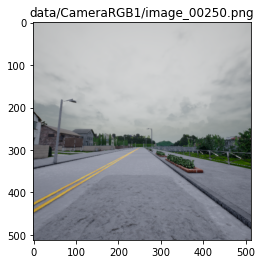

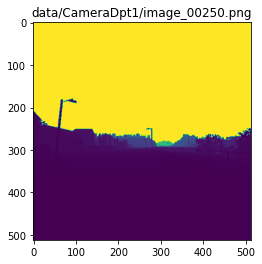

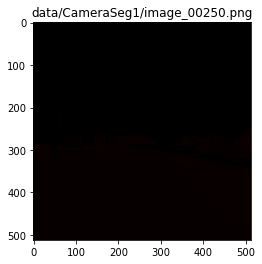

In [38]:
rgb1 = read_rgb(rgb_file1)
depth1 = read_depth(depth_file1)
seg1 = read_rgb(seg_file1)
#print(seg1.type())

12 0


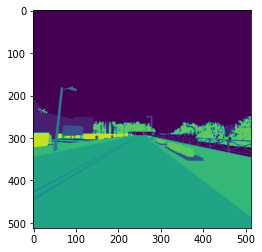

In [39]:
#Semantic labels are contained in the R channel 
R_channel = seg1[:,:,0]
print(R_channel.max(),R_channel.min())
plt.imshow(R_channel)


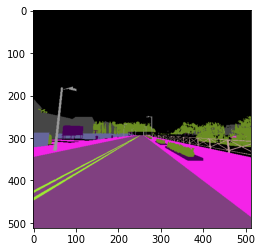

In [14]:
#Convert to cityscapes pallette
cityscapes_seg = labels_to_cityscapes_palette(seg1[:,:,0])
plt.imshow(cityscapes_seg)

In [41]:
pc1, color1 = depth_to_local_point_cloud(depth1, color=rgb1, k = K,max_depth=0.05)
#pc1, seg1 = depth_to_local_point_cloud(depth1, color=cityscapes_seg, k = K,max_depth=0.05)
pc1, seg1 = depth_to_local_point_cloud(depth1, color=seg1, k = K,max_depth=0.05)

In [44]:
print('Number of points in the point cloud: {}'.format(pc1.shape[0]))
print(pc1.shape)    # [X, Y, Z] positions
print(color1) # [R, G, B] values
#print(seg1*255)

Number of points in the point cloud: 120700
(120700, 3)
[[0.56470588 0.57647059 0.61568627]
 [0.50196078 0.51764706 0.56862745]
 [0.57254902 0.58039216 0.60392157]
 ...
 [0.38039216 0.39607843 0.43921569]
 [0.37647059 0.38823529 0.43529412]
 [0.38039216 0.39215686 0.43529412]]


In [36]:
# Save point cloud as .ply to be displayed on Meshlab
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc1)
o3d.io.write_point_cloud("pc_only.ply", pcd)

True

In [37]:
# Save Coloured point cloud as .ply to be displayed on Meshlab
pcdcolour = o3d.geometry.PointCloud()
pcdcolour.points = o3d.utility.Vector3dVector(pc1)
pcdcolour.colors = o3d.utility.Vector3dVector(color1)
o3d.io.write_point_cloud("pc1_colour.ply", pcdcolour)

True

In [38]:
# Save Semantic point cloud as .ply to be displayed on Meshlab
pcdseg = o3d.geometry.PointCloud()
pcdseg.points = o3d.utility.Vector3dVector(pc1)
pcdseg.colors = o3d.utility.Vector3dVector(seg1)
o3d.io.write_point_cloud("pc1_semantic.ply", pcdseg)

True